# Uncertainty Regression


The basic assumption of regression with standard loss function is homoskedasticity, ie, the variance at each measurement is a constant. In reality, it's usually not the case -- the variance at each measurement can vary. We call it heteroskedasticity.

In this notebook, we will study how to take heteroskedascity into consideration when doing non-parametric regression.

### Creating the dataset

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)

Using TensorFlow backend.


/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Number of data points:  2000


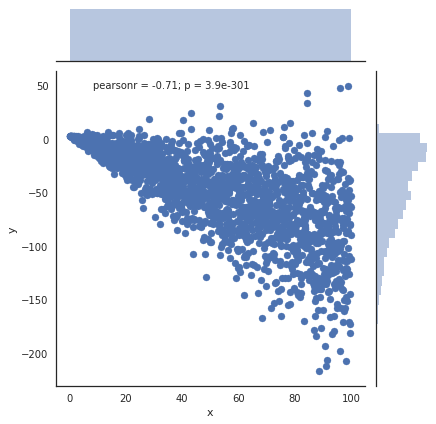

In [2]:
x = np.arange(100, step=0.05)
y = 3-2*x + np.random.normal(x, x/2)
yval = 3-2*x + np.random.normal(x, x/2)
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data)

idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

$x$ is a flat distribution and $y$ is similar to a log-norm distribution. $(y|x)$ is a sum of a Gaussian and a linear function.

### MSE Regressor

In [3]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=10, verbose=1, 
          #callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 911us/step - loss: 908.9476 - val_loss: 879.5744
Epoch 2/100
2000/2000 [==============================] - 1s 493us/step - loss: 859.3703 - val_loss: 872.8219
Epoch 3/100
2000/2000 [==============================] - 1s 510us/step - loss: 835.1596 - val_loss: 900.4357
Epoch 4/100
2000/2000 [======

2000/2000 [==============================] - 1s 542us/step - loss: 822.5438 - val_loss: 887.3027
Epoch 69/100
2000/2000 [==============================] - 1s 546us/step - loss: 824.9568 - val_loss: 873.1385
Epoch 70/100
2000/2000 [==============================] - 1s 567us/step - loss: 819.6871 - val_loss: 878.8812
Epoch 71/100
2000/2000 [==============================] - 1s 541us/step - loss: 818.3990 - val_loss: 893.9308
Epoch 72/100
2000/2000 [==============================] - 1s 530us/step - loss: 820.1935 - val_loss: 873.1986
Epoch 73/100
2000/2000 [==============================] - 1s 535us/step - loss: 820.7821 - val_loss: 876.0327
Epoch 74/100
2000/2000 [==============================] - 1s 556us/step - loss: 818.7008 - val_loss: 873.8495
Epoch 75/100
2000/2000 [==============================] - 1s 553us/step - loss: 819.0085 - val_loss: 874.3079
Epoch 76/100
2000/2000 [==============================] - 1s 564us/step - loss: 821.1035 - val_loss: 870.7643
Epoch 77/100
2000/2000 

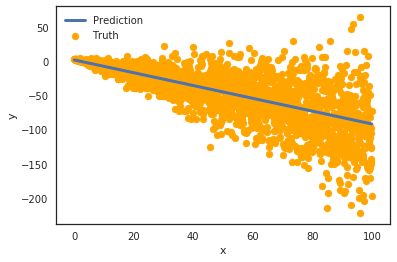

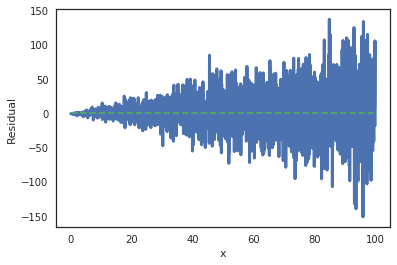

In [4]:
yhat = model.predict(x)
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

As we can see, a simple regression with MSE loss function is good enough for predicting the conditional mean $(y|x)$. However, this regressor has no idea about the uncertainty of its prediction. How can we improve it?

One approach is to reparametrize the output prediction of each point into a pdf $N(\mu, \sigma)$ and maximize its likelihood given the input data. 

### Gaussian Regressor

In [5]:
def InverseSquareRootLinearUnit(args, min_value = 5e-5):
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1.+K.square(args))))

def gauss_loss(y_true, y_pred):
    mu = y_pred[:,0]
    sigma = y_pred[:,1]
    norm_x = K.tf.divide(y_true - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    return K.sum(single_NLL, axis=-1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000)         2000        input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1)            1001        dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            1001        dense_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

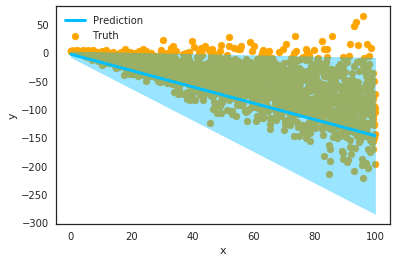

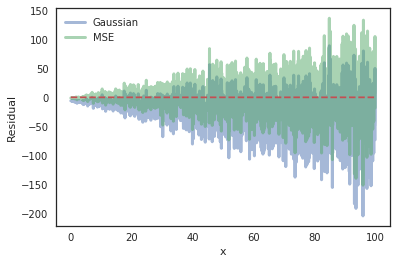

In [6]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output_mu = Dense(1)(hidden)
output_sigma = Dense(1)(hidden)
output_sigma = Lambda(InverseSquareRootLinearUnit)(output_sigma)
output = Concatenate(axis=-1)([output_mu, output_sigma])
Gaussian_model_ordered = Model(inputs, output)
Gaussian_model_ordered.compile(loss=gauss_loss, optimizer='adam')
Gaussian_model_ordered.summary()

# x, y are unshuffled, where x increasing monotonically from 0 to 100.
Gaussian_model_ordered.fit(x, y,
            validation_data=(x,yval),
            epochs=500, batch_size=10, verbose=1, 
            callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
          )

y_gauss = Gaussian_model_ordered.predict(x)
y_gauss_mean = y_gauss[:,0]
y_gauss_var = y_gauss[:,1]

plt.scatter(x,yval, color='orange', label='Truth')
plt.plot(x,y_gauss_mean, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, y_gauss_mean-y_gauss_var,y_gauss_mean+y_gauss_var, alpha=0.4, color='deepskyblue')


plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

plt.figure()
res_ygauss = y_gauss_mean.flatten()-yval
plt.plot(x, res_ygauss, linewidth=3, alpha=0.5, label='Gaussian')
plt.plot(x, res_y, linewidth=3, alpha=0.5, label='MSE')
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend(loc='best')
plt.show()

So far so good: the Guassian model can capture the mean and sigma of the dataset. However, there is one catch: in training I use the unshuffled data, ie, $x$ is a monotonically increasing function. If I use the shuffled $x_{train}, y_{train}$ instead, one would expect nothing change. This is when surprise comes:

In [7]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output_mu = Dense(1)(hidden)
output_sigma = Dense(1)(hidden)
output_sigma = Lambda(InverseSquareRootLinearUnit)(output_sigma)
output = Concatenate(axis=-1)([output_mu, output_sigma])
Gaussian_model = Model(inputs, output)
Gaussian_model.compile(loss=gauss_loss, optimizer='adam')
Gaussian_model.summary()

# x_train, y_train are shuffled in unison.
Gaussian_model.fit(x_train, y_train,  epochs=500, batch_size=10, verbose=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                  validation_data=(x_train, y_trainval))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         2000        input_3[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            1001        dense_6[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1)            1001        dense_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

Epoch 60/500
2000/2000 [==============================] - 1s 719us/step - loss: 47.7880 - val_loss: 48.0619
Epoch 61/500
2000/2000 [==============================] - 1s 726us/step - loss: 47.3766 - val_loss: 47.6194
Epoch 62/500
2000/2000 [==============================] - 1s 737us/step - loss: 46.9343 - val_loss: 47.1548
Epoch 63/500
2000/2000 [==============================] - 1s 710us/step - loss: 46.5459 - val_loss: 46.6905
Epoch 64/500
2000/2000 [==============================] - 1s 713us/step - loss: 45.8711 - val_loss: 46.2313
Epoch 65/500
2000/2000 [==============================] - 1s 717us/step - loss: 45.5869 - val_loss: 45.7904
Epoch 66/500
2000/2000 [==============================] - 1s 714us/step - loss: 45.2327 - val_loss: 45.3791
Epoch 67/500
2000/2000 [==============================] - 1s 721us/step - loss: 44.7133 - val_loss: 45.0121
Epoch 68/500
2000/2000 [==============================] - 1s 707us/step - loss: 44.3588 - val_loss: 44.6973
Epoch 69/500
2000/2000 [====

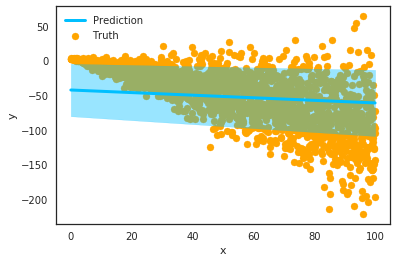

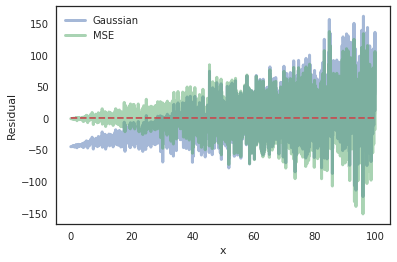

In [8]:
y_gauss = Gaussian_model.predict(x)
y_gauss_mean = y_gauss[:,0]
y_gauss_var = y_gauss[:,1]

plt.scatter(x,yval, color='orange', label='Truth')
plt.plot(x,y_gauss_mean, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, y_gauss_mean-y_gauss_var,y_gauss_mean+y_gauss_var, alpha=0.4, color='deepskyblue')


plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

plt.figure()
res_ygauss = y_gauss_mean.flatten()-yval
plt.plot(x, res_ygauss, linewidth=3, alpha=0.5, label='Gaussian')
plt.plot(x, res_y, linewidth=3, alpha=0.5, label='MSE')
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend(loc='best')
plt.show()

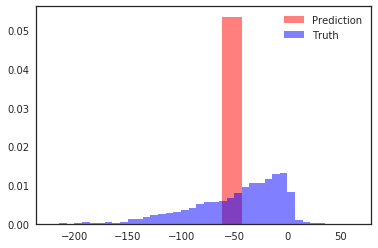

In [9]:
plt.figure()
plt.hist(y_gauss_mean,  bins=40, color='red', alpha=0.5, label='Prediction', density=True)
plt.hist(yval, color='blue', bins=40, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

### Takeaway message
- MSE is good enough if we don't care about uncertainty quantification.
- Don't worry about overfitting if the training data sufficiently covers the whole phase space. "Too many parameters" is a myth in deep neural network.
- Parametrize the output to estimate the PDF only works under certain situations.